In [3]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [4]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [5]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

##### it is having details about the tool condition we build our custom logic also

https://github.com/langchain-ai/langgraph/blob/main/libs/langgraph/langgraph/prebuilt/tool_node.py

why we use from langchain_core.pydantic_v1 import BaseModel, Field

The import statement:

```python
from langchain_core.pydantic_v1 import BaseModel, Field
```

indicates that you're working within the **LangChain ecosystem** and leveraging **Pydantic** for data validation and model creation. Here's a breakdown of **why and how** these components are used:

---

### **Why Use `BaseModel` and `Field` from Pydantic?**

Pydantic is a powerful library for data validation and settings management in Python. It is particularly well-suited for building models that ensure your data conforms to specific types and formats.

In the context of LangChain, **Pydantic's `BaseModel` and `Field`** are often used to define structured schemas for:

1. **Tool Input and Output Models:**  
   - Define the input and output structure for tools or LLM-based functions.
   - Ensures the data being passed to or returned from the tools is valid and well-defined.

2. **Prompts and Contexts:**  
   - Create reusable, structured representations of prompts or conversation states.

3. **Validation and Type Enforcement:**  
   - Validate that data passed between components (e.g., tools, LLMs, and workflows) adheres to expected types and constraints.

4. **Better Readability and Debugging:**  
   - Explicitly define schemas for tools and workflows, making your code easier to understand and debug.

---

### **How These Components Work**

#### **1. `BaseModel`**
Pydantic's `BaseModel` is the foundation for creating structured models. It allows you to:
- Define the expected fields of a model.
- Add validation logic for those fields.
- Automatically handle type coercion and validation errors.

#### **2. `Field`**
The `Field` class is used to:
- Add metadata, constraints, or default values to model fields.
- Document the purpose of each field.

---

### **Examples**

#### **Tool Input Model**
Suppose you are defining a tool that takes user input. You can use `BaseModel` and `Field` to structure the expected input:

```python
from langchain_core.pydantic_v1 import BaseModel, Field

class MathToolInput(BaseModel):
    number1: float = Field(..., description="The first number for the operation")
    number2: float = Field(..., description="The second number for the operation")
    operation: str = Field(..., description="The operation to perform: add, subtract, multiply, or divide")

# Example usage
input_data = MathToolInput(number1=10, number2=5, operation="add")
print(input_data.dict())  # {'number1': 10.0, 'number2': 5.0, 'operation': 'add'}
```

This ensures:
- Only valid operations (e.g., "add") are processed.
- Invalid or missing data raises a clear validation error.

---

#### **Structured Prompts**
You can use `BaseModel` to create reusable, structured prompts for LLMs:

```python
class SummarizationPrompt(BaseModel):
    text: str = Field(..., description="The text to summarize")
    max_length: int = Field(100, description="Maximum length of the summary")

prompt = SummarizationPrompt(text="This is a long article...", max_length=50)
print(prompt.dict())  # {'text': 'This is a long article...', 'max_length': 50}
```

---

#### **Tool Input Validation**
You can integrate these models directly into LangChain tools:

```python
from langchain_core.pydantic_v1 import BaseModel
from langchain.tools import BaseTool

class RetrieveBlogPostsInput(BaseModel):
    query: str = Field(..., description="The search query for blog posts")
    max_results: int = Field(10, description="The maximum number of blog posts to return")

class RetrieveBlogPostsTool(BaseTool):
    name = "retrieve_blog_posts"
    description = "Retrieve blog posts based on a search query"
    args_schema = RetrieveBlogPostsInput  # Link the schema

    def _run(self, query: str, max_results: int):
        return f"Retrieved {max_results} results for query: {query}"

# Example usage
tool = RetrieveBlogPostsTool()
print(tool.run(query="AI advancements", max_results=5))  # Retrieves the results
```

---

### **Benefits of Using `BaseModel` and `Field`**

1. **Type Safety:**  
   - Ensures data integrity across components.
   
2. **Descriptive Errors:**  
   - Automatically raises clear validation errors for invalid input.

3. **Reusability:**  
   - Define input/output models once and reuse them in multiple tools or workflows.

4. **Self-Documentation:**  
   - The `Field` metadata (e.g., `description`) makes your code easier to understand and maintain.

5. **Interoperability:**  
   - These structured models are compatible with LangChain's tooling and workflows, making them a natural choice in this ecosystem.

---

Let me know if you’d like help with implementing these models for your specific use case! 😊

In [6]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [45]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [46]:
llm.invoke("hi hello how are you?")

AIMessage(content="As an AI, I don't have feelings, but I'm here and ready to help! How can I assist you today? 😊\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 15, 'total_tokens': 47, 'completion_time': 0.058181818, 'prompt_time': 8.122e-05, 'queue_time': 0.021134570000000002, 'total_time': 0.058263038}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-191e479d-91c0-4b4e-99cf-a6da40bd5294-0', usage_metadata={'input_tokens': 15, 'output_tokens': 32, 'total_tokens': 47})

In [8]:
url= "https://lilianweng.github.io/posts/2023-06-23-agent/"

In [9]:
WebBaseLoader(url).load()

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [10]:
WebBaseLoader(url).load()[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

In [11]:
description=WebBaseLoader(url).load()[0].metadata["description"]

In [12]:
description

'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model 

In [13]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [14]:
docs = [WebBaseLoader(url).load() for url in urls]

In [15]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [16]:
docs_list = [item for sublist in docs for item in sublist]

In [17]:
docs_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [18]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=5)

In [19]:
doc_splits=text_splitter.split_documents(docs_list)

In [20]:
doc_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [21]:
vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings
    
)

In [22]:
retriever=vectorstore.as_retriever()

In [23]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    
)

In [24]:
tools=[retriever_tool]

In [25]:
retrieve=ToolNode([retriever_tool])

In [22]:
llm_with_tools=llm.bind_tools(tools)

In [ ]:
llm_with_tools.invoke(["hi how are you can you tell me what is india's capital?"])

In [ ]:
llm_with_tools.invoke(["who is a prime minister of india?"])

In [ ]:
llm_with_tools.invoke(["hi can you tell me what is llm agent?"])

In [ ]:
llm_with_tools.invoke(["How does short-term memory (in-context learning) differ from long-term memory in an LLM-powered autonomous agent system?"])

Certainly! Let's break down the code:

### **Code Breakdown:**

```python
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
```

This code defines a class `AgentState` that is a **`TypedDict`**, which is a special kind of dictionary with fixed keys and value types, used to provide better type safety and autocompletion in Python.

Here’s a breakdown of each part:

---

### **1. `AgentState(TypedDict)`**
- **`TypedDict`**: This is a special class provided by `typing` that allows you to define dictionaries where each key has a fixed type. The dictionary keys are usually predefined, and each key must have a specified type.

  - `AgentState` here is a subclass of `TypedDict`, meaning `AgentState` will represent a dictionary where the types of its values are enforced.

  - Example:
    ```python
    agent_state = AgentState(messages=["Message 1", "Message 2"])  # This would be valid.
    ```

---

### **2. `messages: Annotated[Sequence[BaseMessage], add_messages]`**
- **`messages`**: This is a key in the `AgentState` dictionary. It holds a sequence (like a list or tuple) of `BaseMessage` objects.
  
- **`Annotated[...]`**: `Annotated` is used to attach additional metadata or annotations to the type. It’s a way to add extra information to the type system without affecting the actual type. In this case, it provides metadata for the `messages` field. 

  - The **`Annotated`** wrapper allows you to define a type and also include additional information that might be used by tools like static analyzers or for other purposes like validation.

- **`Sequence[BaseMessage]`**: This indicates that `messages` should be a sequence (e.g., a list or tuple) of `BaseMessage` objects.

  - **`BaseMessage`** is likely a class that represents a message in the context of your program. It could have fields like `content`, `sender`, `timestamp`, etc.
  
- **`add_messages`**: This is a special annotation (or metadata) that likely refers to some function or constant that’s being added as additional context. The specific role of `add_messages` will depend on how it's defined elsewhere in the codebase.

  - **`add_messages`** could be a function, validator, or modifier that helps manage or process the messages in some way, but it's not directly modifying the type of `messages`. It's simply metadata for the type checker or other parts of the system.

  - For example, if `add_messages` were a function, it could be used in a custom decorator, validation system, or simply as an indication of how to handle messages.

---

### **Putting It All Together:**

- **`AgentState`** is a dictionary where one of the keys, `messages`, is specifically typed to be a **sequence of `BaseMessage`** objects. The sequence is annotated with **`add_messages`**, which provides additional metadata but doesn’t affect the type directly.
  
- **Example of `AgentState` usage:**

```python
from typing import TypedDict, Sequence
from typing_extensions import Annotated

class BaseMessage:
    def __init__(self, content: str):
        self.content = content

# Defining the `AgentState` TypedDict
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], "add_messages"]

# Example usage
message1 = BaseMessage("Hello, world!")
message2 = BaseMessage("How are you?")
state = AgentState(messages=[message1, message2])

print(state)
```

In the above code:
- `AgentState` is a dictionary with a `messages` field that is a sequence of `BaseMessage` objects.
- `add_messages` is metadata associated with the `messages` field, which can help guide the usage or interpretation of the data.

---

### **Summary:**
- `AgentState` is a dictionary where the `messages` key holds a sequence of `BaseMessage` objects.
- `Annotated[Sequence[BaseMessage], add_messages]` means that `messages` is a sequence of `BaseMessage` objects with additional metadata (`add_messages`).
- The annotation `add_messages` provides extra context or metadata that doesn't alter the type directly but can be used for purposes like validation or other system-specific behavior.

Let me know if you'd like further clarification on any part of this! 😊

In [26]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [67]:
'''def handle_query(query):
    print(query[0])
    if "prompt" in query[0] or "agent" in query[0]:
        return llm_with_tools.invoke(query)  # Use tool-bound LLM
    else:
        return llm.invoke(query)  # Use LLM directly without tool'''

In [126]:
def ai_assistant(state:AgentState):
    print("---CALL AGENT---")
    messages = state['messages']
    print(f"this is my message: {messages}")
    
    if len(messages)>1:
        response=llm.invoke(messages[-1].content)
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        #response=handle_query(messages)
        return {"messages": [response]}

In [108]:
{"messages":["hi hello how are you?"]}

{'messages': ['hi hello how are you?']}

In [ ]:
ai_assistant({"messages":["hi hello how are you?"]})

In [ ]:
ai_assistant({"messages":["what is autonomous agent"]})

Let's break down the code:

```python
class grade(BaseModel):
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")
```

This code defines a **Pydantic model** called `grade`, which is a subclass of **`BaseModel`**. The model is used to enforce the structure and data validation for a specific object. Here’s a detailed breakdown of each part:

---

### **1. `class grade(BaseModel):`**
- **`BaseModel`**: This is a class from the **Pydantic** library. By subclassing `BaseModel`, the `grade` class inherits Pydantic's functionality, which includes data validation, parsing, and automatic type checks.
  - When you define a model with Pydantic's `BaseModel`, it ensures that the data being processed conforms to the defined types and validates the fields according to their specified types.

- **`grade`**: This is the name of the model. It represents a grading system (or some other form of assessment) with a specific field, `binary_score`.

---

### **2. `binary_score: str = Field(description="Relevance score 'yes' or 'no'")`**
- **`binary_score`**: This is a field in the `grade` model. It holds the score related to relevance.
  - It is typed as a `str` (string) and is expected to hold a value of `'yes'` or `'no'`.

- **`Field(description="Relevance score 'yes' or 'no'")`**:  
  - **`Field`**: This is a Pydantic function that is used to add metadata to model fields. In this case, it describes the field in the model.
  - The **`description`** argument provides a brief explanation of what the field represents, which helps improve documentation and readability of the code. This metadata doesn't change the field's behavior but can be helpful for generating documentation or providing context.

---

### **What Does This Model Do?**
- **The `grade` model** represents an object where the `binary_score` field holds a string value, specifically `'yes'` or `'no'`, indicating a relevance score.
- The **`description`** metadata is useful for documenting that this field specifically holds a binary score, either 'yes' or 'no'.

---

### **Example Usage**

You can create an instance of this model and validate the data automatically, thanks to Pydantic:

```python
from pydantic import BaseModel, Field

# Define the grade model
class grade(BaseModel):
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")

# Example usage: create an instance of grade
score = grade(binary_score="yes")
print(score)
```

#### Output:
```python
grade(binary_score='yes')
```

- If you try to create an instance with a value other than `'yes'` or `'no'`, Pydantic will raise a validation error, because the type and values are strictly defined.

#### Invalid Example:
```python
score = grade(binary_score="maybe")  # Raises validation error
```

#### Error:
```python
pydantic.error_wrappers.ValidationError: 1 validation error for grade
binary_score
  value is not a valid string (type=value_error.str)
```

---

### **Summary:**
- The **`grade` model** defines a **binary relevance score** (`binary_score`), where the score should be `'yes'` or `'no'`.
- **Pydantic's `Field`** is used to add a description to this field, explaining its purpose.
- By subclassing `BaseModel`, this model automatically provides data validation, ensuring that the `binary_score` is a valid string and provides automatic error handling if invalid data is provided.

Let me know if you'd like further explanation or examples! 😊

In [109]:
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score 'yes' or 'no'")

In [110]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op
    
    messages = state["messages"]
    print(f"message from the grader: {messages}")
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

### from langchain hub we can fetch the prompt

In [111]:
prompt = hub.pull("rlm/rag-prompt")

In [112]:
prompt.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [113]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]
    
    print(f"here is message from generate: {messages}")
    
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")
    
    return {"messages": [response]}

In [114]:
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    print(f"here is message from rewrite: {messages}")
    
    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [127]:
workflow=StateGraph(AgentState)
workflow.add_node("My_AI_Assistant",ai_assistant)
workflow.add_node("Vector_Retriever", retrieve) 
workflow.add_node("Query_Rewriter", rewrite) 
workflow.add_node("Output_Generator", generate)

In [128]:
workflow.add_edge(START,"My_AI_Assistant")

In [129]:
workflow.add_conditional_edges("My_AI_Assistant",
                               tools_condition,
                               {"tools": "Vector_Retriever",
                                END: END,})

In [130]:
workflow.add_conditional_edges("Vector_Retriever",
                            grade_documents,
                            {"generator": "Output_Generator",
                            "rewriter": "Query_Rewriter"
                            }
                            )
                            

In [131]:
workflow.add_edge("Output_Generator", END)

In [132]:
workflow.add_edge("Query_Rewriter", "My_AI_Assistant")

In [133]:
app=workflow.compile()

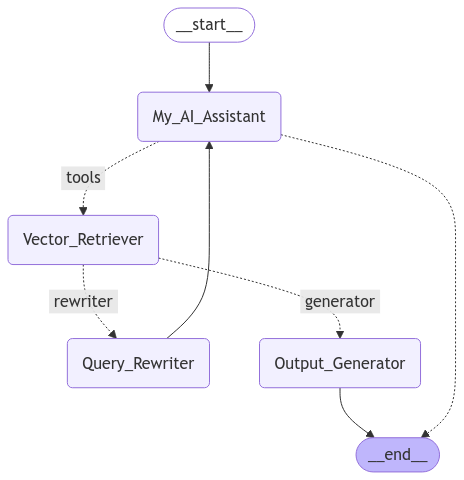

In [134]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [135]:
app.invoke({"messages":["What is a Autonomous Agent?"]})

---CALL AGENT---
this is my message: [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='464623cf-33b6-44ac-a039-ed7e8165a4dc')]
message from the grader: [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='464623cf-33b6-44ac-a039-ed7e8165a4dc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fs8w', 'function': {'arguments': '{"query":"What is an autonomous agent?"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 1039, 'total_tokens': 1126, 'completion_time': 0.158181818, 'prompt_time': 0.032804583, 'queue_time': 0.020830077000000002, 'total_time': 0.190986401}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1a2e6495-63e5-40fd-8c8e-32f8ceb6f979-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'quer

{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='464623cf-33b6-44ac-a039-ed7e8165a4dc'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fs8w', 'function': {'arguments': '{"query":"What is an autonomous agent?"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 1039, 'total_tokens': 1126, 'completion_time': 0.158181818, 'prompt_time': 0.032804583, 'queue_time': 0.020830077000000002, 'total_time': 0.190986401}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1a2e6495-63e5-40fd-8c8e-32f8ceb6f979-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'What is an autonomous agent?'}, 'id': 'call_fs8w', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1039, 'output_tokens': 87, 'total_tokens': 1126}),
  ToolMessage(content='Age

In [136]:
app.invoke({"messages":["What is a prompt engineering?"]})

---CALL AGENT---
this is my message: [HumanMessage(content='What is a prompt engineering?', additional_kwargs={}, response_metadata={}, id='54666639-dbba-4495-9bef-9d8bc1385023')]
message from the grader: [HumanMessage(content='What is a prompt engineering?', additional_kwargs={}, response_metadata={}, id='54666639-dbba-4495-9bef-9d8bc1385023'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xamq', 'function': {'arguments': '{"query":"What is prompt engineering?"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 1039, 'total_tokens': 1126, 'completion_time': 0.158181818, 'prompt_time': 0.033114402, 'queue_time': 0.022006397999999996, 'total_time': 0.19129622}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f8333b79-d438-4473-9975-c34770c21a5a-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'qu

{'messages': [HumanMessage(content='What is a prompt engineering?', additional_kwargs={}, response_metadata={}, id='54666639-dbba-4495-9bef-9d8bc1385023'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xamq', 'function': {'arguments': '{"query":"What is prompt engineering?"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 1039, 'total_tokens': 1126, 'completion_time': 0.158181818, 'prompt_time': 0.033114402, 'queue_time': 0.022006397999999996, 'total_time': 0.19129622}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f8333b79-d438-4473-9975-c34770c21a5a-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'What is prompt engineering?'}, 'id': 'call_xamq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1039, 'output_tokens': 87, 'total_tokens': 1126}),
  ToolMessage(content='Prom

In [137]:
app.invoke({"messages":["who is a current prime minister of india?"]})

---CALL AGENT---
this is my message: [HumanMessage(content='who is a current prime minister of india?', additional_kwargs={}, response_metadata={}, id='97c67380-9a32-4b43-bf51-82b9aef1bc46')]
message from the grader: [HumanMessage(content='who is a current prime minister of india?', additional_kwargs={}, response_metadata={}, id='97c67380-9a32-4b43-bf51-82b9aef1bc46'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pjn9', 'function': {'arguments': '{"query":"who is the current prime minister of india"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 1042, 'total_tokens': 1132, 'completion_time': 0.163636364, 'prompt_time': 0.033002873, 'queue_time': 0.022563100999999995, 'total_time': 0.196639237}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-18032813-5d5e-4c37-ba65-2ee6df4715f8-0', tool_calls=[{'na

{'messages': [HumanMessage(content='who is a current prime minister of india?', additional_kwargs={}, response_metadata={}, id='97c67380-9a32-4b43-bf51-82b9aef1bc46'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pjn9', 'function': {'arguments': '{"query":"who is the current prime minister of india"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 1042, 'total_tokens': 1132, 'completion_time': 0.163636364, 'prompt_time': 0.033002873, 'queue_time': 0.022563100999999995, 'total_time': 0.196639237}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-18032813-5d5e-4c37-ba65-2ee6df4715f8-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'who is the current prime minister of india'}, 'id': 'call_pjn9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1042, 'output_tokens': 90, 'total_t

In [103]:
app.invoke({"messages":["what is solar eclips?"]})

---CALL AGENT---
this is my message: [HumanMessage(content='what is solar eclips?', additional_kwargs={}, response_metadata={}, id='911216b7-d732-4709-98a3-fa5a0da77763')]
message from the grader: [HumanMessage(content='what is solar eclips?', additional_kwargs={}, response_metadata={}, id='911216b7-d732-4709-98a3-fa5a0da77763'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8vq8', 'function': {'arguments': '{"query":"What is a solar eclipse?"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 1038, 'total_tokens': 1126, 'completion_time': 0.16, 'prompt_time': 0.03288589, 'queue_time': 0.022693677000000002, 'total_time': 0.19288589}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6600f0b8-b81a-491a-a298-1448fc3b57e0-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'What is a solar ecli

{'messages': [HumanMessage(content='what is solar eclips?', additional_kwargs={}, response_metadata={}, id='911216b7-d732-4709-98a3-fa5a0da77763'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8vq8', 'function': {'arguments': '{"query":"What is a solar eclipse?"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 1038, 'total_tokens': 1126, 'completion_time': 0.16, 'prompt_time': 0.03288589, 'queue_time': 0.022693677000000002, 'total_time': 0.19288589}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6600f0b8-b81a-491a-a298-1448fc3b57e0-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'What is a solar eclipse?'}, 'id': 'call_8vq8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1038, 'output_tokens': 88, 'total_tokens': 1126}),
  ToolMessage(content='unclear areas} remaining q

In [105]:
app.invoke({"messages":["how we can use data structure for fundamental part of planning?"]})

---CALL AGENT---
this is my message: [HumanMessage(content='how we can use data structure for fundamental part of planning?', additional_kwargs={}, response_metadata={}, id='bde204fe-0bcd-4f36-8db0-a0faaf7cedb9')]
message from the grader: [HumanMessage(content='how we can use data structure for fundamental part of planning?', additional_kwargs={}, response_metadata={}, id='bde204fe-0bcd-4f36-8db0-a0faaf7cedb9'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mxqk', 'function': {'arguments': '{"query":"How can we use data structures for fundamental part of planning?"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 1045, 'total_tokens': 1139, 'completion_time': 0.170909091, 'prompt_time': 0.033084362, 'queue_time': 0.022047862, 'total_time': 0.203993453}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-

{'messages': [HumanMessage(content='how we can use data structure for fundamental part of planning?', additional_kwargs={}, response_metadata={}, id='bde204fe-0bcd-4f36-8db0-a0faaf7cedb9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mxqk', 'function': {'arguments': '{"query":"How can we use data structures for fundamental part of planning?"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 1045, 'total_tokens': 1139, 'completion_time': 0.170909091, 'prompt_time': 0.033084362, 'queue_time': 0.022047862, 'total_time': 0.203993453}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a24eca17-b45a-4366-abda-e359c3e8a16c-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'How can we use data structures for fundamental part of planning?'}, 'id': 'call_mxqk', 'type': 'tool_call'}], usage_meta

In [106]:
app.invoke({"messages":["what finance minister does for fundamental planning?"]})

---CALL AGENT---
this is my message: [HumanMessage(content='what finance minister does for fundamental planning?', additional_kwargs={}, response_metadata={}, id='70c572f4-e419-4bb0-90db-423196824df7')]
message from the grader: [HumanMessage(content='what finance minister does for fundamental planning?', additional_kwargs={}, response_metadata={}, id='70c572f4-e419-4bb0-90db-423196824df7'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r5c1', 'function': {'arguments': '{"query":"What does a finance minister do for fundamental planning?"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1041, 'total_tokens': 1133, 'completion_time': 0.167272727, 'prompt_time': 0.033288981, 'queue_time': 0.020403077999999998, 'total_time': 0.200561708}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3a7762da-b303-44ae-8

{'messages': [HumanMessage(content='what finance minister does for fundamental planning?', additional_kwargs={}, response_metadata={}, id='70c572f4-e419-4bb0-90db-423196824df7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r5c1', 'function': {'arguments': '{"query":"What does a finance minister do for fundamental planning?"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1041, 'total_tokens': 1133, 'completion_time': 0.167272727, 'prompt_time': 0.033288981, 'queue_time': 0.020403077999999998, 'total_time': 0.200561708}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3a7762da-b303-44ae-89e2-5daac1b28b41-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'What does a finance minister do for fundamental planning?'}, 'id': 'call_r5c1', 'type': 'tool_call'}], usage_metadata={'input_tok

In [ ]:
This is a fundamental part of planning, breaking down complex tasks into smaller, manageable ones, often used in agent systems for better execution.